<a href="https://colab.research.google.com/github/Simonlee711/Neural-Ordinary-Differential-Equations/blob/main/NeuralODE__CrashCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchdiffeq

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchdiffeq import odeint_adjoint as odeint
from tqdm.auto import tqdm  # Use auto to automatically select the best interface (notebook vs terminal)
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms


# Define the ODE function (derivative)
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, t, x):
        return self.relu(self.linear(x))

# Define the ODE block that integrates the ODEFunc
class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc

    def forward(self, x):
        # Integrate from t=0 to t=1
        return odeint(self.odefunc, x, torch.tensor([0, 1], dtype=torch.float32), method='dopri5')[1]

# Define the Neural ODE model for MNIST classification
class ODEModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.ode_block = ODEBlock(ODEFunc(28*28))
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.ode_block(x)
        return self.fc(x)

# Load MNIST data
import torch
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Determine the fraction of the dataset to use
fraction = 0.1

# Calculate subset sizes
train_subset_size = int(len(train_dataset) * fraction)
test_subset_size = int(len(test_dataset) * fraction)

# Randomly sample indices for training and testing subsets
train_subset_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_subset_indices = torch.randperm(len(test_dataset))[:test_subset_size]

# Create subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(test_dataset, test_subset_indices)

# Create DataLoaders for the subsets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=1000, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ODEModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f'Train Epoch: {epoch} \tAverage Loss: {sum(losses)/len(losses):.6f}')

print("Training")
for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, epoch)

def test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():  # No need to track gradients for testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Assuming you have already defined and trained your model...
# Assuming `test_loader` is defined and loaded with MNIST test dataset...

# Now call the test function
test(model, device, test_loader)


Training


Epoch 1:   0%|          | 0/94 [00:00<?, ?it/s]

Train Epoch: 1 	Average Loss: 0.473369


Epoch 2:   0%|          | 0/94 [00:00<?, ?it/s]

Train Epoch: 2 	Average Loss: 0.194595


Epoch 3:   0%|          | 0/94 [00:00<?, ?it/s]

Train Epoch: 3 	Average Loss: 0.108640


Epoch 4:   0%|          | 0/94 [00:00<?, ?it/s]

Train Epoch: 4 	Average Loss: 0.056942


Epoch 5:   0%|          | 0/94 [00:00<?, ?it/s]

Train Epoch: 5 	Average Loss: 0.045413


In [8]:
# Define a hook for capturing inputs and outputs
inputs, outputs = [], []
def capture_hook(module, input, output):
    inputs.append(input[0].detach())  # input is a tuple
    outputs.append(output.detach())

# Attach the hook to the ODE block
model.ode_block.register_forward_hook(capture_hook)



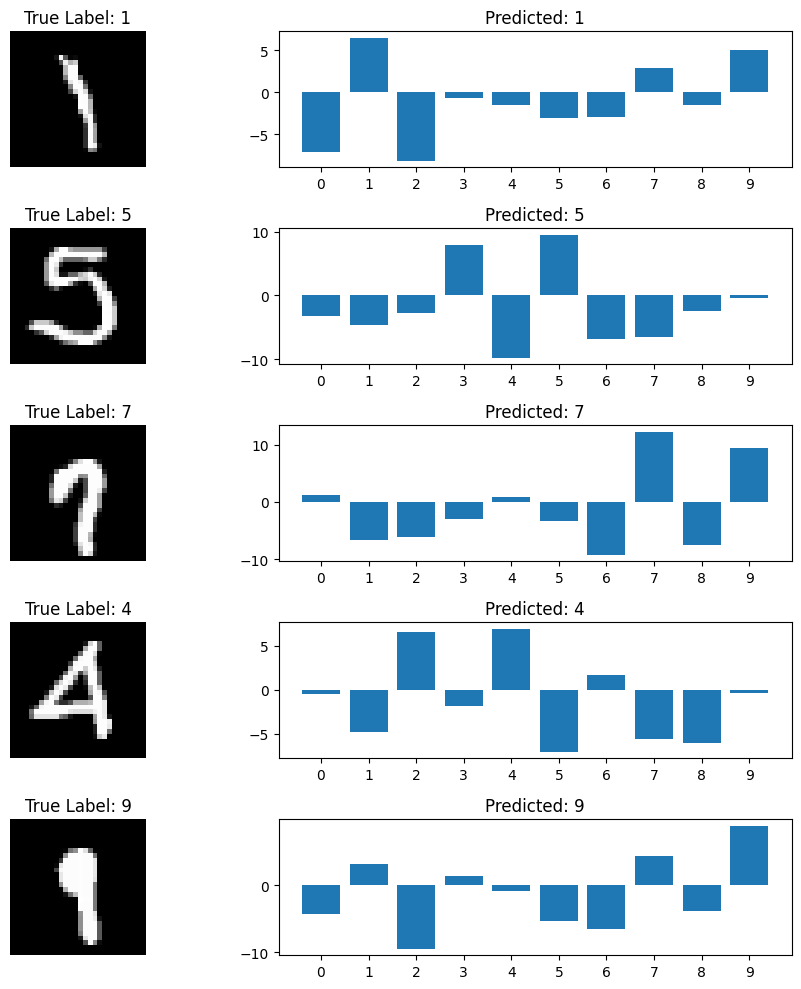

In [10]:
def test_and_visualize_decisions(model, device, test_loader, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))  # Adjust for number of samples

    # Ensure we only visualize as many samples as we have subplots for
    num_visualized_samples = 0

    with torch.no_grad():
        for data, target in test_loader:
            if num_visualized_samples >= num_samples:
                break
            data, target = data.to(device), target.to(device)
            output = model(data)

            for idx in range(data.size(0)):
                if num_visualized_samples >= num_samples:
                    break

                # Visualize the input image
                axs[num_visualized_samples, 0].imshow(data[idx].cpu().squeeze(), cmap='gray')
                axs[num_visualized_samples, 0].set_title(f"True Label: {target[idx].item()}")
                axs[num_visualized_samples, 0].axis('off')

                # Visualize the logits as a bar chart
                logits = output[idx].cpu().numpy()
                axs[num_visualized_samples, 1].bar(range(10), logits)
                axs[num_visualized_samples, 1].set_title(f"Predicted: {logits.argmax()}")
                axs[num_visualized_samples, 1].set_xticks(range(10))
                axs[num_visualized_samples, 1].set_xticklabels(range(10))

                num_visualized_samples += 1

    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
# Call the function again
test_and_visualize_decisions(model, device, test_loader)


In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def visualize_ode_dynamics(model, device, data_loader, timesteps=np.linspace(0, 1, 5)):
    model.eval()
    with torch.no_grad():
        # Get a single batch from the data loader
        data, _ = next(iter(data_loader))
        data = data.to(device)

        # Flatten the data and pass through the ODE block to capture dynamics
        data_flattened = data.view(data.size(0), -1)

        # Specifying adjoint_params explicitly
        adjoint_params = tuple(model.ode_block.odefunc.parameters())

        def func(t, x):
            return model.ode_block.odefunc(t, x)

        # Use the odeint function with specified adjoint_params
        ode_solutions = odeint(func, data_flattened, torch.tensor(timesteps).to(device), method='dopri5', adjoint_params=adjoint_params)


        # Use PCA to project the high-dimensional trajectory data to 2D for visualization
        pca = PCA(n_components=2)
        ode_solutions_2d = pca.fit_transform(ode_solutions.permute(1, 0, 2).reshape(-1, data_flattened.shape[1]).cpu().numpy())

        # Plot the 2D projections of the ODE trajectories
        plt.figure(figsize=(12, 8))
        for i in range(len(timesteps)):
            plt.scatter(ode_solutions_2d[i::len(timesteps), 0], ode_solutions_2d[i::len(timesteps), 1], label=f'Time={timesteps[i]:.2f}')
        plt.legend()
        plt.title('2D PCA Projection of MNIST Data Dynamics Through NODE')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()


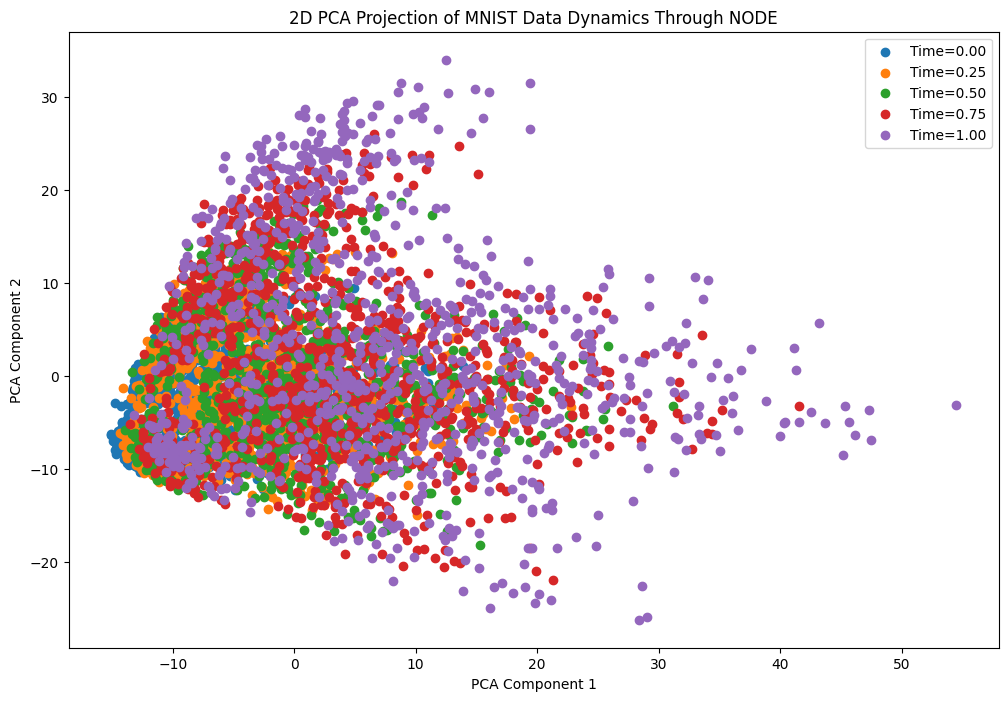

In [15]:
# Make sure the model and test_loader are defined and the model is trained
visualize_ode_dynamics(model, device, test_loader)
